In [1]:
import pandas as pd
import numpy as np
import itertools
import re, os
import string
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from collections import defaultdict

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.externals import joblib

#### Experiment

In [3]:
sen = data['Text'][2]
#print sen, type(sen)
strg = sen.encode('utf-8')
#print sen.encode('utf-8'), type(sen.encode('utf-8'))
'''if '- ' in sen:
    sen1 = re.sub('- ', '', sen)
print sen1
'''
strg = BeautifulSoup(strg, "lxml").get_text()
print strg

strg1 = re.sub('- ', '', strg)
print strg1
print strg1[-32]
strg2 = re.sub('[^a-zA-Z]',' ', strg1)
print strg2
strg2 = strg2.lower()
sent = re.sub('and', '', strg2)
print sent
words = sent.split()
print words
stop_words = stopwords.words('english')
important_words = [w for w in words if not w in stop_words]
' '.join(important_words)

NameError: name 'data' is not defined

In [4]:
'The ayris'.lower().split()

['the', 'ayris']

In [6]:
def sentence_to_words(raw_sentence):
    """This function modifies the sentences to words by removing html marks,
    non-letters etc."""
    
    sent_text = BeautifulSoup(raw_sentence.encode('utf-8'), "lxml").get_text()  # Remove HTML markings
    if '- ' in sent_text:                            
        sent_text = re.sub('- ', '', sent_text)    # join the words split by line change
    letters = re.sub('[^a-zA-Z]', ' ', sent_text)  # Remove non-letters: all special chars, numbers, puncs etc.
    words = letters.lower().split()
    stop_words = stopwords.words('english')
    important_words = [w for w in words if not w in stop_words]
    return ' '.join(important_words)

In [5]:
'''if drug_g == drug_g:  # Check for nan values
    drug = re.sub('[^a-zA-Z1-9]', ' ', drug_g)
    sent = re.sub(str(drug.lower()), '', sent)  # Remove Drug Names
    words = sent.split()
else:'''

"if drug_g == drug_g:  # Check for nan values\n    drug = re.sub('[^a-zA-Z1-9]', ' ', drug_g)\n    sent = re.sub(str(drug.lower()), '', sent)  # Remove Drug Names\n    words = sent.split()\nelse:"

In [7]:
def stemming(text):
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(w) for w in text]

In [8]:
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

In [7]:
class df_column_extractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def transform(self, df, y=None):
        return df[[self.column]]
            
    def fit(self, df, y=None):
        return self

In [8]:
class Converter(BaseEstimator, TransformerMixin):
    def transform(self, df, y=None):
        return df.values.ravel()
            
    def fit(self, df, y=None):
        return self

In [9]:
sentence_to_words('A 31 year old wo- man had fever and he took__)(^%crocin. After that he started having rash.')

u'year old woman fever took crocin started rash'

#### Reading Data

In [11]:
data = pd.read_excel(r'C:\Users\binit.kumar.bhagat\Documents\PV First\Drug Classification\Model Improvement\Data For Model Training 10_Jul.xlsx', sheetname='Final')
data.columns = ['Case ID','Drug Role','Trade Name','Generic Name','Text']
data.shape

(1005, 5)

In [15]:
data['Text'][0]

u'He presented in November 1991, 3 hours after ingestion of 30 ibuprofen 400 mg tablets'

#### Text Cleaning

In [16]:
clean_text = []
for i in range(len(data)):
    #print data['Generic Name'][i],i
    clean_text.append(sentence_to_words(data['Text'][i]))

In [17]:
len(clean_text)

1005

In [18]:
clean_text

[u'presented november hours ingestion ibuprofen mg tablets',
 u'patient appears developed proximal tubular dysfunction first evidenced presence orthoglycemic glycosuria glycosuria normal blood glucose developed approximately years initiated therapy nucleotide reverse transcriptase inhibitor tenofovir',
 u'constellation blood urinary derangements coupled proximal tubular epithelial cells urinary sediment consistent proximal tubular injury fanconi syndrome likely secondary tenofovir',
 u'renal biopsy revealed toxic acute tubular necrosis predominantly involving proximal tubules consistent tenofovir toxicity',
 u'fanconi syndrome result either inborn error metabolism result tubular toxicity drug induced renal fanconi syndrome uncommon reported several antiretroviral medications including tenofovir',
 u'although prospective clinical trials demonstrated low incidence renal toxicity tenofovir',
 u'first tenofovir related renal toxicity case described fanconi syndrome acute renal failure neph

### Remove all the drug names from the text

#### Collate all Drugs

In [19]:
drug_gen = list(set(data['Generic Name']))
print 'Generic Names: ',len(drug_gen)
drug_trd = list(set(data['Trade Name']))
print 'Trade Names: ',len(drug_trd)
drug_list = list(set(drug_gen+drug_trd))
print 'Drug List: ',len(drug_list)

Generic Names:  334
Trade Names:  87
Drug List:  394


#### Remove nan, convert drug names to lowercase and strip leading and trailing whitespaces

In [20]:
drug_list = [x.lower().strip() for x in drug_list if x==x]
print len(drug_list)
#print drug_list

393


#### Cleaning and tokenizing the drug names

In [21]:
drug_list1 = []
for drug in drug_list:
    letters = re.sub('[^a-zA-Z]', ' ', drug)  # Remove non-letters: all special chars, numbers, puncs etc.
    drugs = letters.lower().split()
    for d in drugs:
        drug_list1.append(d)
print drug_list1

[u'didanosine', u'telmisartan', u'glibenclamide', u'chlorpromazine', u'hydrochloride', u'cpz', u'nitroglycerin', u'atenolol', u'lithium', u'gabapentin', u'pracet', u'dopamine', u'low', u'molecular', u'weight', u'heparin', u'levetiracetam', u'fluoxetine', u'citalopram', u'modified', u'release', u'verapamil', u'haloperidol', u'phosphate', u'supplements', u'cimzia', u'chlorpromazine', u'hydrochloride', u'indapamide', u'venlafaxine', u'hydrochloride', u'procarbazine', u'obsidan', u'tramadol', u'hydrocortisone', u'mg', u'hourly', u'diamox', u'temozolomide', u'benzodiazepine', u'ticlopidine', u'guaifenesin', u'enalapril', u'salbutamol', u'sulfate', u'digoxin', u'clomipramine', u'vimpat', u'propaphenin', u'betamethasone', u'alpha', u'methyldopa', u'doxorubicin', u'cyclosporine', u'morphine', u'amoxicillin', u'pronase', u'nitroglycerine', u'dicumarine', u'urokinase', u'frusemide', u'morphine', u'tacrolimus', u'methotrexaat', u'inh', u'insulin', u'atorvastatin', u'bleomycin', u'adapin', u'norvi

#### Removing All drug names

In [22]:
clean_text1 = []
for i in range(len(clean_text)):
    s = clean_text[i].split()
    s1 = [x for x in s if not x in drug_list1]
    clean_text1.append(' '.join(s1))

In [23]:
len(clean_text1)

1005

In [24]:
clean_text1

[u'presented november hours ingestion tablets',
 u'patient appears developed proximal tubular dysfunction first evidenced presence orthoglycemic glycosuria glycosuria blood developed approximately years initiated therapy nucleotide reverse transcriptase inhibitor',
 u'constellation blood urinary derangements coupled proximal tubular epithelial cells urinary sediment consistent proximal tubular injury fanconi syndrome likely secondary',
 u'renal biopsy revealed toxic acute tubular necrosis predominantly involving proximal tubules consistent toxicity',
 u'fanconi syndrome result either inborn error metabolism result tubular toxicity drug induced renal fanconi syndrome uncommon reported several antiretroviral medications including',
 u'although prospective clinical trials demonstrated incidence renal toxicity',
 u'first related renal toxicity case described fanconi syndrome acute renal failure nephrogenic diabetes insipidus temporally associated use drug improved drug cessation',
 u'shown

#### Stemming and Lemmitization

In [25]:
stemmed_text = stemming(clean_text1)
lemmatized_text = lemmatization(clean_text1)

In [26]:
data['Clean_Text'], data['Stemmed'], data['Lemmatized'] = clean_text1, stemmed_text, lemmatized_text

In [27]:
data

,Case ID,Drug Role,Trade Name,Generic Name,Text,Clean_Text,Stemmed,Lemmatized
0,full text- 763,Suspect,NaN,Ibuprofen,"He presented in November 1991, 3 hours after i...",presented november hours ingestion tablets,presented november hours ingestion tablet,presented november hours ingestion tablets
1,full text- 919,Suspect,NaN,Tenofovir,This patient appears to have developed proxima...,patient appears developed proximal tubular dys...,patient appears developed proximal tubular dys...,patient appears developed proximal tubular dys...
2,full text- 919,Suspect,NaN,Tenofovir,This constellation of blood and urinary derang...,constellation blood urinary derangements coupl...,constellation blood urinary derangements coupl...,constellation blood urinary derangements coupl...
3,full text- 919,Suspect,NaN,Tenofovir,Renal biopsy revealed toxic acute tubular necr...,renal biopsy revealed toxic acute tubular necr...,renal biopsy revealed toxic acute tubular necr...,renal biopsy revealed toxic acute tubular necr...
4,full text- 919,Suspect,NaN,Tenofovir,Fanconi syndrome is the result of either an in...,fanconi syndrome result either inborn error me...,fanconi syndrome result either inborn error me...,fanconi syndrome result either inborn error me...
5,full text- 919,Suspect,NaN,Tenofovir,Although prospective clinical trials have demo...,although prospective clinical trials demonstra...,although prospective clinical trials demonstra...,although prospective clinical trials demonstra...
6,full text- 919,Suspect,NaN,Tenofovir,The first tenofovir-related renal toxicity cas...,first related renal toxicity case described fa...,first related renal toxicity case described fa...,first related renal toxicity case described fa...
7,full text- 919,Suspect,NaN,Tenofovir,Tenofovir has been shown to cause renal proxim...,shown cause renal proximal tubular mitochondri...,shown cause renal proximal tubular mitochondri...,shown cause renal proximal tubular mitochondri...
8,full text- 919,Suspect,NaN,Tenofovir,Although the exact mechanism of tubular injury...,although exact mechanism tubular injury associ...,although exact mechanism tubular injury associ...,although exact mechanism tubular injury associ...
9,full text- 919,Suspect,NaN,Tenofovir,Current recommendations suggest close monitor-...,current recommendations suggest close monitori...,current recommendations suggest close monitori...,current recommendations suggest close monitori...


In [221]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

#### Frequency

In [28]:
data['Frequency'] = np.ones(len(data), dtype=int)
for i in range(len(data)):
    data['Frequency'][i] = int(len(data[(data['Case ID']==data['Case ID'][i]) & (data['Generic Name']==data['Generic Name'][i])]))

C:\Users\binit.kumar.bhagat\AppData\Local\conda\conda\envs\python27\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
data[:200]

,Case ID,Drug Role,Trade Name,Generic Name,Text,Clean_Text,Stemmed,Lemmatized,Frequency
0,full text- 763,Suspect,NaN,Ibuprofen,"He presented in November 1991, 3 hours after i...",presented november hours ingestion tablets,presented november hours ingestion tablet,presented november hours ingestion tablets,1
1,full text- 919,Suspect,NaN,Tenofovir,This patient appears to have developed proxima...,patient appears developed proximal tubular dys...,patient appears developed proximal tubular dys...,patient appears developed proximal tubular dys...,9
2,full text- 919,Suspect,NaN,Tenofovir,This constellation of blood and urinary derang...,constellation blood urinary derangements coupl...,constellation blood urinary derangements coupl...,constellation blood urinary derangements coupl...,9
3,full text- 919,Suspect,NaN,Tenofovir,Renal biopsy revealed toxic acute tubular necr...,renal biopsy revealed toxic acute tubular necr...,renal biopsy revealed toxic acute tubular necr...,renal biopsy revealed toxic acute tubular necr...,9
4,full text- 919,Suspect,NaN,Tenofovir,Fanconi syndrome is the result of either an in...,fanconi syndrome result either inborn error me...,fanconi syndrome result either inborn error me...,fanconi syndrome result either inborn error me...,9
5,full text- 919,Suspect,NaN,Tenofovir,Although prospective clinical trials have demo...,although prospective clinical trials demonstra...,although prospective clinical trials demonstra...,although prospective clinical trials demonstra...,9
6,full text- 919,Suspect,NaN,Tenofovir,The first tenofovir-related renal toxicity cas...,first related renal toxicity case described fa...,first related renal toxicity case described fa...,first related renal toxicity case described fa...,9
7,full text- 919,Suspect,NaN,Tenofovir,Tenofovir has been shown to cause renal proxim...,shown cause renal proximal tubular mitochondri...,shown cause renal proximal tubular mitochondri...,shown cause renal proximal tubular mitochondri...,9
8,full text- 919,Suspect,NaN,Tenofovir,Although the exact mechanism of tubular injury...,although exact mechanism tubular injury associ...,although exact mechanism tubular injury associ...,although exact mechanism tubular injury associ...,9
9,full text- 919,Suspect,NaN,Tenofovir,Current recommendations suggest close monitor-...,current recommendations suggest close monitori...,current recommendations suggest close monitori...,current recommendations suggest close monitori...,9


#### Data Distribution

In [30]:
data['Drug Role'].value_counts()

Suspect        753
Concomitant    130
Treatment      122
Name: Drug Role, dtype: int64

#### Target Modification

In [31]:
data['Drug Role'] = data['Drug Role'].replace('Suspect','Not Concomitant').replace('Treatment','Not Concomitant')

In [32]:
data['Drug Role'].value_counts()

Not Concomitant    875
Concomitant        130
Name: Drug Role, dtype: int64

#### Set X and y

In [33]:
X = data.drop('Drug Role', axis=1)
y = data['Drug Role']

### Stratified K-Fold Cross Validation

In [34]:
skf = StratifiedKFold(n_splits=5, random_state=111)
for train_index, val_index in skf.split(X,y): 
    print("Train:", train_index, "Validation:", val_index) 
    print 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
    X_train, X_test = X.iloc[train_index], X.iloc[val_index] 
    y_train, y_test = y[train_index], y[val_index]

('Train:', array([ 191,  192,  193,  194,  195,  196,  198,  199,  200,  201,  202,
        203,  204,  205,  206,  207,  208,  209,  210,  211,  212,  213,
        214,  215,  216,  217,  218,  219,  220,  221,  222,  223,  224,
        225,  226,  227,  228,  229,  230,  231,  232,  233,  234,  235,
        236,  237,  238,  239,  240,  241,  242,  243,  244,  245,  246,
        247,  249,  250,  251,  252,  253,  254,  255,  256,  257,  258,
        259,  260,  261,  262,  263,  264,  265,  266,  267,  272,  273,
        274,  275,  276,  277,  278,  279,  280,  281,  282,  283,  284,
        287,  288,  289,  290,  291,  292,  293,  294,  295,  296,  297,
        298,  299,  300,  301,  302,  304,  305,  306,  307,  308,  309,
        310,  311,  313,  314,  315,  316,  317,  318,  319,  320,  321,
        322,  323,  324,  325,  326,  327,  328,  329,  330,  331,  332,
        333,  334,  335,  336,  337,  338,  339,  340,  341,  342,  343,
        344,  345,  346,  347,  348,  34

### Classifiers

In [35]:
forest = RandomForestClassifier(n_estimators=500, random_state=300)
svm = SVC(C=0.3, gamma=0.1, kernel='linear', random_state=200, probability=True)

### Pipeline and Featureunion

In [36]:
vec_svd_pipe = Pipeline([('stem', df_column_extractor('Stemmed')),
                         ('convert', Converter()),
                         ('vec', TfidfVectorizer(analyzer="word", ngram_range=(1,2), max_df=0.8, max_features=3000)),
                         ('svd', TruncatedSVD(n_components=510, n_iter=10, random_state=222))
                        ])

In [37]:
word_features = vec_svd_pipe.fit_transform(data)

C:\Users\binit.kumar.bhagat\AppData\Local\conda\conda\envs\python27\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [38]:
word_features.shape

(1005L, 510L)

In [39]:
word_features

array([[ 0.06017919, -0.01872658, -0.025059  , ...,  0.0037466 ,
        -0.01754256, -0.04525754],
       [ 0.09002122, -0.02309975, -0.0691495 , ...,  0.01391905,
        -0.0182654 ,  0.03348741],
       [ 0.02667828, -0.00724128, -0.04590132, ..., -0.01011958,
         0.02022873, -0.01771022],
       ...,
       [ 0.04162036, -0.00914183, -0.02903487, ..., -0.01017771,
        -0.00534046, -0.0227387 ],
       [ 0.14700676, -0.05050034, -0.174945  , ..., -0.00278459,
        -0.00787668, -0.00903331],
       [ 0.22990538, -0.06847562, -0.20401794, ...,  0.05376595,
        -0.02538939, -0.02847404]])

In [78]:
vect = TfidfVectorizer(analyzer="word", ngram_range=(1,2), max_df=0.8, max_features=3000)

In [79]:
feats = vect.fit_transform(X_train['Stemmed'])

In [80]:
indices = np.argsort(vect.idf_)[::-1]
features = vect.get_feature_names()
top_n = 20
top_features = [features[i] for i in indices[:top_n]]
print top_features

[u'iu day', u'kcl', u'dose major', u'hyperglycaemia', u'per minute', u'infiltrated', u'fractionated', u'nodal', u'inguinal', u'rv', u'inhalant', u'mm hg', u'depression administered', u'pharmaceuticals', u'lomustine', u'inhibiting', u'significant postural', u'mitochondrial', u'lower extremity', u'nucleoside']


In [82]:
features_by_gram = defaultdict(list)
for f, w in zip(vect.get_feature_names(), vect.idf_):
    features_by_gram[len(f.split(' '))].append((f, w))
top_n = 10
for gram, features in features_by_gram.iteritems():
    top_features = sorted(features, key=lambda x: x[1], reverse=True)[:top_n]
    top_features = [f[0] for f in top_features]
    print '{}-gram top:'.format(gram), top_features

1-gram top: [u'apheresis', u'bed', u'diplopia', u'disturbance', u'dp', u'ear', u'emotional', u'european', u'extended', u'extremity']
2-gram top: [u'depression administered', u'dose major', u'dose thrice', u'european society', u'female neonate', u'group received', u'hearing loss', u'inspiratory pressure', u'iu day', u'ketamine increased']


#### Main Pipeline

In [40]:
model = forest
pipeline = Pipeline([('union', FeatureUnion([                     
                         ('vec_svd', vec_svd_pipe),
                         ('freq', df_column_extractor('Frequency'))
                                            ])),
                     ('model', model)
                    ])

In [41]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('vec_svd', Pipeline(memory=None,
     steps=[('stem', df_column_extractor(column='Stemmed')), ('convert', Converter()), ('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>,...imators=500, n_jobs=1,
            oob_score=False, random_state=300, verbose=0, warm_start=False))])

In [42]:
pred = pipeline.predict(X_test)

In [43]:
print 'Accuracy = ',accuracy_score(y_test, pred)
print '\n',classification_report(y_test, pred)
print '\n', confusion_matrix(y_test, pred)

Accuracy =  0.8706467661691543

                 precision    recall  f1-score   support

    Concomitant       0.00      0.00      0.00        26
Not Concomitant       0.87      1.00      0.93       175

    avg / total       0.76      0.87      0.81       201


[[  0  26]
 [  0 175]]


C:\Users\binit.kumar.bhagat\AppData\Local\conda\conda\envs\python27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### K-Fold Accuracy Test

In [139]:
X = data.drop('Drug Role', axis=1)
y = data['Drug Role']
skf = StratifiedKFold(n_splits=5, random_state=111)
index = 0
for train_index, val_index in skf.split(X,y): 
    if index>3:
        break
    else:
        #print("Train:", train_index, "Validation:", val_index) 
        #print 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
        X_train, X_test = X.iloc[train_index], X.iloc[val_index] 
        y_train, y_test = y[train_index], y[val_index]

        pipeline.fit(X_train, y_train)
        pred = pipeline.predict(X_test)
        print '\n\n{}-Fold Accuracy = '.format(index+1),accuracy_score(y_test, pred)
        print '\n',classification_report(y_test, pred)
        print '\n', confusion_matrix(y_test, pred)
        index += 1



1-Fold Accuracy =  0.875621890547

                 precision    recall  f1-score   support

    Concomitant       1.00      0.04      0.07        26
Not Concomitant       0.88      1.00      0.93       175

    avg / total       0.89      0.88      0.82       201


[[  1  25]
 [  0 175]]


2-Fold Accuracy =  0.885572139303

                 precision    recall  f1-score   support

    Concomitant       0.71      0.19      0.30        26
Not Concomitant       0.89      0.99      0.94       175

    avg / total       0.87      0.89      0.86       201


[[  5  21]
 [  2 173]]


3-Fold Accuracy =  0.910447761194

                 precision    recall  f1-score   support

    Concomitant       1.00      0.31      0.47        26
Not Concomitant       0.91      1.00      0.95       175

    avg / total       0.92      0.91      0.89       201


[[  8  18]
 [  0 175]]


4-Fold Accuracy =  0.975124378109

                 precision    recall  f1-score   support

    Concomitant       1.00   

#### Selecting hyperparameters

#### SVM

Accuracy= 0.950248756219 	C= 13.5 	Gamma= 0.01 	Kernel= rbf
Accuracy= 0.950248756219 	C= 13.6 	Gamma= 0.01 	Kernel= rbf
Accuracy= 0.950248756219 	C= 13.7 	Gamma= 0.01 	Kernel= rbf
Accuracy= 0.950248756219 	C= 13.8 	Gamma= 0.01 	Kernel= rbf
Accuracy= 0.950248756219 	C= 13.9 	Gamma= 0.01 	Kernel= rbf
Accuracy= 0.950248756219 	C= 14.0 	Gamma= 0.01 	Kernel= rbf
Accuracy= 0.950248756219 	C= 14.1 	Gamma= 0.01 	Kernel= rbf
Accuracy= 0.950248756219 	C= 14.2 	Gamma= 0.01 	Kernel= rbf
Accuracy= 0.950248756219 	C= 14.3 	Gamma= 0.01 	Kernel= rbf
Accuracy= 0.950248756219 	C= 14.4 	Gamma= 0.01 	Kernel= rbf
Accuracy= 0.950248756219 	C= 14.5 	Gamma= 0.01 	Kernel= rbf
Accuracy= 0.950248756219 	C= 14.6 	Gamma= 0.01 	Kernel= rbf


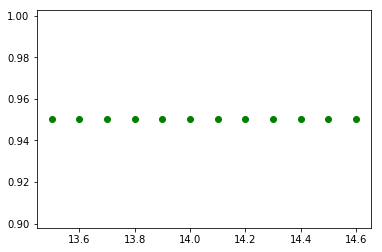

In [117]:
#C_list = np.arange(13.5, 14.7, 0.1)
C_list = [i for i in range(10,30) if i%1 == 0]
g_list = [1e-2]
k_list = ['rbf']
acc_list = []

for k in k_list:
    for c in C_list:
        for g in g_list:        
            
            svm = SVC(C=c, gamma=g, kernel=k, random_state=200, probability=False)
            model = svm
            pipeline = Pipeline([('union', FeatureUnion([                     
                                     ('vec_svd', vec_svd_pipe),
                                     ('freq', df_column_extractor('Frequency'))
                                                        ])),
                                 ('model', model)
                                ])
            pipeline.fit(X_train, y_train)
            pred = pipeline.predict(X_test)
            acc = accuracy_score(y_test, pred)
            print 'Accuracy=',acc,'\tC=', c,'\tGamma=', g,'\tKernel=', k
            acc_list.append(acc)
n = len(g_list)   
new_list = [y for x in C_list for y in n*[x]]
plt.plot(new_list, acc_list, 'go')
plt.show()

In [ ]:
Accuracy= 0.950248756219 	C= 0.3 	Gamma= 0.1 	Kernel= linear
Accuracy= 0.950248756219 	C= 14.0 	Gamma= 0.01 	Kernel= rbf
Accuracy= 0.925373134328 	C= 400 	Gamma= 0.001 	Kernel= rbf
Accuracy= 0.925373134328 	C= 75 	Gamma= 0.01 	Kernel= sigmoid

#### RandomForest

Accuracy= 0.960199004975 	No. of trees =  50
Accuracy= 0.960199004975 	No. of trees =  100
Accuracy= 0.975124378109 	No. of trees =  150
Accuracy= 0.970149253731 	No. of trees =  200
Accuracy= 0.970149253731 	No. of trees =  250
Accuracy= 0.970149253731 	No. of trees =  300
Accuracy= 0.970149253731 	No. of trees =  350
Accuracy= 0.975124378109 	No. of trees =  400
Accuracy= 0.975124378109 	No. of trees =  450
Accuracy= 0.975124378109 	No. of trees =  500


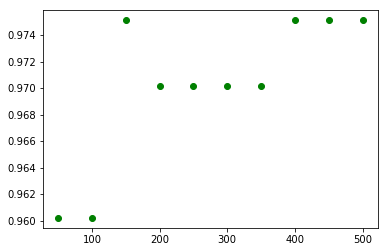

In [140]:
accu_list = []
x_list = [i for i in range(50, 550) if i%50 == 0]

for x in x_list:        

    forest = RandomForestClassifier(n_estimators=x, random_state=300)
    model = forest
    pipeline = Pipeline([('union', FeatureUnion([                     
                             ('vec_svd', vec_svd_pipe),
                             ('freq', df_column_extractor('Frequency'))
                                                ])),
                         ('model', model)
                        ])
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    accu = accuracy_score(y_test, pred)
    print 'Accuracy=',accu,'\tNo. of trees = ', x
    accu_list.append(accu)

plt.plot(x_list, accu_list, 'go')
plt.show()

In [ ]:
Accuracy= 0.975124378109 	No. of trees =  500

### Selecting number of components

Accuracy= 0.950248756219 	n_comp= 150
Accuracy= 0.950248756219 	n_comp= 200
Accuracy= 0.950248756219 	n_comp= 250
Accuracy= 0.975124378109 	n_comp= 300
Accuracy= 0.965174129353 	n_comp= 350
Accuracy= 0.965174129353 	n_comp= 400
Accuracy= 0.965174129353 	n_comp= 450
Accuracy= 0.975124378109 	n_comp= 500
Accuracy= 0.970149253731 	n_comp= 550
Accuracy= 0.965174129353 	n_comp= 600


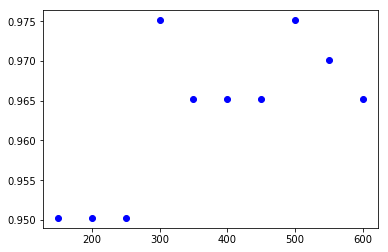

In [141]:
comp_list = [i for i in range(150,650) if i%50 == 0]

forest = RandomForestClassifier(n_estimators=500, random_state=300)
svm = SVC(C=14.0, gamma=0.01, kernel='rbf', random_state=200, probability=True)

for model in [forest]:
    accu_list = []
    for comp in comp_list:   
        
        vec_svd_pipe = Pipeline([('stem', df_column_extractor('Stemmed')),
                             ('convert', Converter()),
                             ('vec', TfidfVectorizer(analyzer="word", ngram_range=(1,2), max_df=0.8, max_features=3000)),
                             ('svd', TruncatedSVD(n_components=comp, n_iter=10, random_state=222))
                            ])

        pipeline = Pipeline([('union', FeatureUnion([                     
                                 ('vec_svd', vec_svd_pipe),
                                 ('freq', df_column_extractor('Frequency'))
                                                    ])),
                             ('model', model)
                            ])
        pipeline.fit(X_train, y_train)
        pred = pipeline.predict(X_test)
        accu = accuracy_score(y_test, pred)
        print 'Accuracy=',accu,'\tn_comp=', comp
        accu_list.append(accu)
    plt.plot(comp_list, accu_list, 'bo')
    plt.show()

In [ ]:
Accuracy= 0.975124378109 	n_comp= 510 model = forest
Accuracy= 0.950248756219 	n_comp= 600 model = svm, k=linear
Accuracy= 0.950248756219 	n_comp= 500 model = svm, k=rbf

In [249]:
print 'Final Model=RF, n=440, comp=300, Acc=98'

Final Model=RF, n=440, comp=300, Acc=98


### Saving the Model

In [265]:
path = r'C:\Users\binit\Documents\PV First\Drug Classification\PKL files'

In [267]:
joblib.dump(pipeline, r'C:\Users\binit\Documents\PV First\Drug Classification\PKL files\forest_1005_21Jul_no_drug_98.pkl')

['C:\\Users\\binit\\Documents\\PV First\\Drug Classification\\PKL files\\forest_1005_21Jul_no_drug_98.pkl']

#### Loading Model

In [269]:
clf = joblib.load(r'C:\Users\binit\Documents\PV First\Drug Classification\PKL files\forest_1005_21Jul_no_drug_98.pkl')

In [270]:
new_pred = clf.predict(X_test)

In [274]:
print 'Final Results:\nAccuracy = '.format(index+1),accuracy_score(y_test, pred)
print '\n',classification_report(y_test, pred)
print '\nConfusion Matrix:\n', confusion_matrix(y_test, pred)

Final Results:
Accuracy =  0.980099502488

                 precision    recall  f1-score   support

    Concomitant       1.00      0.85      0.92        26
Not Concomitant       0.98      1.00      0.99       175

    avg / total       0.98      0.98      0.98       201


Confusion Matrix:
[[ 22   4]
 [  0 175]]
